In [19]:
import pandas as pd

In [20]:
crime = pd.read_csv("crime_weather_preprocessed")
print(crime.columns)
print(crime.shape[0])

Index(['dow', 'hour_of_day', 'offense_date', 'temp_max', 'temp_min',
       'daylight_duration', 'precipitation_sum', 'precipitation_hours',
       'extracted_month', 'extracted_day', 'ucr_desc_numeric',
       'offense_year_numeric', 'time_block_numeric', 'census_tract_numeric',
       'census_block_numeric'],
      dtype='object')
360042


In [21]:
crime['offense_date'] = pd.to_datetime(crime['offense_date'], errors='coerce')

crime.set_index('offense_date', inplace=True)

In [5]:
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).agg({
    'dow': 'mean',  
    'hour_of_day': 'mean',
    'extracted_month': 'mean',
    'extracted_day': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'daylight_duration': 'mean',
    'precipitation_sum': 'mean',
    'precipitation_hours': 'mean',
    'time_block_numeric': 'mean'
}).reset_index()

crime_time_series['Crime_Count_W'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).size().values

crime_time_series_seq = crime_time_series.sort_values(by='offense_date')

crime_time_series = crime_time_series.drop(columns=['offense_date'])

crime_time_series

,census_block_numeric,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_W
0,0,3.612903,10.774194,1.000000,3.419355,14.012673,2.872995,33396.085874,0.036132,8.258065,1.225806,62
1,0,3.931818,13.840909,1.000000,10.727273,39.481495,25.380132,33891.959251,0.225304,8.454545,1.000000,44
2,0,3.800000,14.171429,1.000000,18.028571,33.977197,18.672054,34573.083036,0.036670,4.057143,0.800000,35
3,0,4.017857,12.696429,1.000000,24.625000,46.487669,32.168027,35307.395717,0.092238,7.750000,1.178571,56
4,0,4.780488,11.317073,1.658537,11.878049,33.318698,17.041868,36302.567645,0.059823,7.024390,1.268293,41
...,...,...,...,...,...,...,...,...,...,...,...,...
33332,239,4.000000,0.000000,7.000000,13.000000,79.916000,63.986000,53716.195312,0.051181,4.000000,3.000000,1
33333,239,1.000000,7.500000,7.000000,31.000000,83.606003,61.916000,51864.425781,0.000000,0.000000,1.500000,2
33334,239,5.000000,17.000000,9.000000,29.000000,57.866001,44.456001,42640.847656,0.031496,4.000000,0.000000,1
33335,239,5.000000,0.000000,12.000000,1.000000,33.206001,24.746000,33854.109375,0.007874,2.000000,3.000000,1


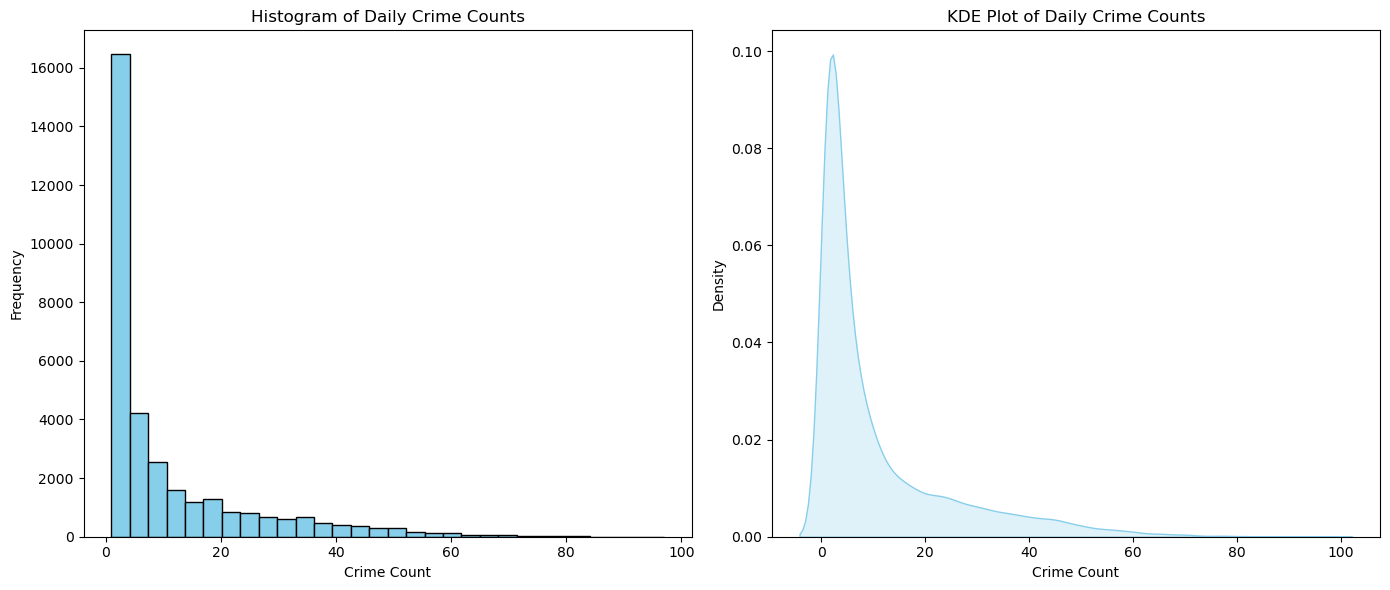

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Crime_Count' is the column with daily crime counts
crime_counts = crime_time_series['Crime_Count_W']

# Set up the figure for multiple visualizations
plt.figure(figsize=(14, 6))

# Histogram to show the distribution of daily crime counts
plt.subplot(1, 2, 1)
plt.hist(crime_counts, bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Crime Count')
plt.ylabel('Frequency')
plt.title('Histogram of Daily Crime Counts')

# KDE (Kernel Density Estimate) plot for a smooth frequency distribution
plt.subplot(1, 2, 2)
sns.kdeplot(crime_counts, fill=True, color='skyblue')
plt.xlabel('Crime Count')
plt.ylabel('Density')
plt.title('KDE Plot of Daily Crime Counts')

# Show both visualizations
plt.tight_layout()
plt.show()

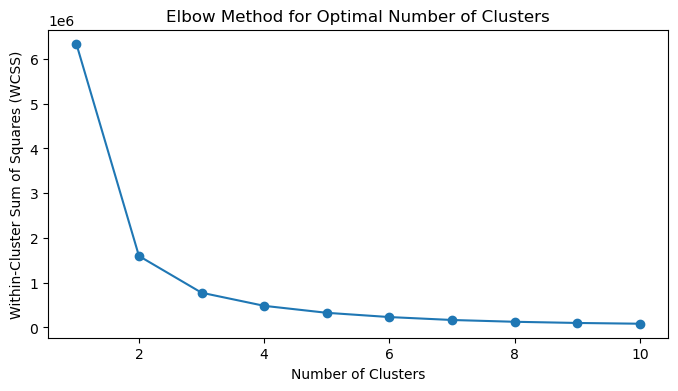

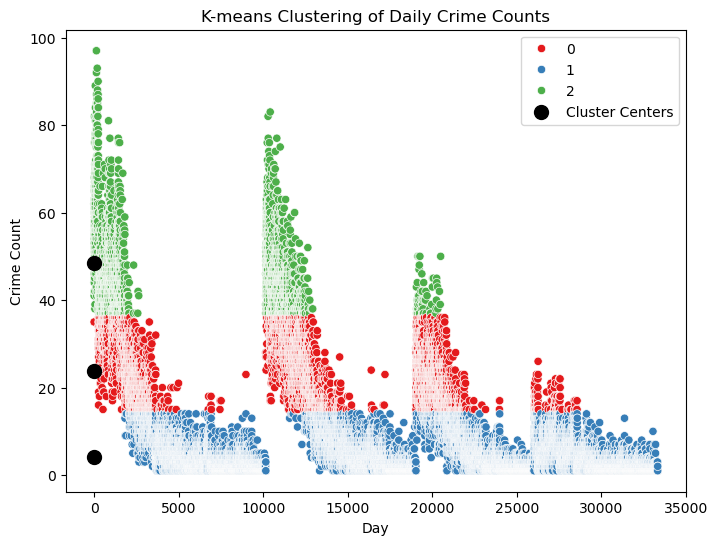

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'Crime_Count' is the column with daily crime counts
crime_counts = crime_time_series['Crime_Count_W'].values.reshape(-1, 1)

# Determine optimal clusters for K-means using the elbow method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(crime_counts)
    wcss.append(kmeans.inertia_)

# Plot the elbow method results
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

# Apply K-means clustering with an optimal number of clusters (let’s assume 3 for this example)
optimal_clusters = 3
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
crime_counts_kmeans_labels = kmeans.fit_predict(crime_counts)

# Add the cluster labels as bins in the DataFrame
crime_time_series['Crime_KMeans_Bin'] = crime_counts_kmeans_labels

# Visualize K-means cluster centers
plt.figure(figsize=(8, 6))
sns.scatterplot(x=range(len(crime_counts)), y=crime_counts.flatten(), hue=crime_counts_kmeans_labels, palette='Set1')
plt.scatter(range(len(kmeans.cluster_centers_)), kmeans.cluster_centers_, color='black', label='Cluster Centers', s=100)
plt.title('K-means Clustering of Daily Crime Counts')
plt.xlabel('Day')
plt.ylabel('Crime Count')
plt.legend()
plt.show()

# Hierarchical clustering and dendrogram
linked = linkage(crime_counts, method='ward')
plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Dendrogram for Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.show()

# Apply hierarchical clustering with the chosen number of clusters (e.g., 3)
hierarchical = AgglomerativeClustering(n_clusters=optimal_clusters, affinity='euclidean', linkage='ward')
crime_counts_hierarchical_labels = hierarchical.fit_predict(crime_counts)

# Add the cluster labels from hierarchical clustering as bins
crime_time_series['Crime_Hierarchical_Bin'] = crime_counts_hierarchical_labels

# Visualize the hierarchical clustering results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=range(len(crime_counts)), y=crime_counts.flatten(), hue=crime_counts_hierarchical_labels, palette='Set2')
plt.title('Hierarchical Clustering of Daily Crime Counts')
plt.xlabel('Day')
plt.ylabel('Crime Count')
plt.show()

# Display cluster-based bins added to the data
print(crime_time_series[['Crime_Count', 'Crime_KMeans_Bin', 'Crime_Hierarchical_Bin']].head(10))

In [22]:
crime_time_series.columns

Index(['census_block_numeric', 'offense_date', 'dow', 'hour_of_day',
       'extracted_month', 'extracted_day', 'temp_max', 'temp_min',
       'daylight_duration', 'precipitation_sum', 'precipitation_hours',
       'time_block_numeric'],
      dtype='object')

In [101]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def k_fold_cross_validation(model, X, y, k=5, random_state=42):
    kf = KFold(n_splits=k, shuffle=True, random_state=random_state)
    fold_metrics = []

    mae_list, rmse_list, r2_list = [], [], []
    all_y_test = [] 
    all_y_pred = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        all_y_test.extend(y_test)
        all_y_pred.extend(y_pred)

        mae = mean_absolute_error(y_test, y_pred)
        rmse = mean_squared_error(y_test, y_pred, squared=False)
        r2 = r2_score(y_test, y_pred)
        mae_list.append(mae)
        rmse_list.append(rmse)
        r2_list.append(r2)

        print(f"Fold {fold + 1} Metrics:")
        print(f"  Mean Absolute Error (MAE): {mae}")
        print(f"  Root Mean Squared Error (RMSE): {rmse}")
        print(f"  R² Score: {r2}\n")

        fold_metrics.append((mae, rmse, r2))

    avg_mae = np.mean(mae_list)
    avg_rmse = np.mean(rmse_list)
    avg_r2 = np.mean(r2_list)

    print(f"Average MAE across {k} folds: {avg_mae}")
    print(f"Average RMSE across {k} folds: {avg_rmse}")
    print(f"Average R² Score across {k} folds: {avg_r2}")

    plt.figure(figsize=(12, 8))
    plt.plot(all_y_test, label='Actual Crime Count', color='blue')
    plt.plot(all_y_pred, label='Predicted Crime Count', linestyle='--', color='red')
    plt.legend()
    plt.title(f'Actual vs. Predicted Crime Count (Weekly) - Comprehensive Plot Across {k} Folds')
    plt.xlabel('Combined Test Samples from All Folds')
    plt.ylabel('Crime Count')
    plt.show()

    return avg_mae, avg_rmse, avg_r2, fold_metrics

In [6]:
features = ['census_block_numeric', 'dow', 'hour_of_day', 'extracted_month', 
            'extracted_day', 'temp_max', 'temp_min', 'daylight_duration', 
            'precipitation_sum', 'precipitation_hours', 'time_block_numeric']
X = crime_time_series[features]
y = crime_time_series['Crime_Count_W']

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.7248035392921413
  Root Mean Squared Error (RMSE): 4.5061835389809195
  R² Score: 0.8900716186061632



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.6929124175164967
  Root Mean Squared Error (RMSE): 4.512534163536557
  R² Score: 0.894462123943491



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.6667646617669116
  Root Mean Squared Error (RMSE): 4.429530798272585
  R² Score: 0.8958417326780777



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.7127463626818655
  Root Mean Squared Error (RMSE): 4.432888437013191
  R² Score: 0.8957087423697819



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.7167721613919307
  Root Mean Squared Error (RMSE): 4.509961994533922
  R² Score: 0.8966550535517848

Average MAE across 5 folds: 2.7027998285298693
Average RMSE across 5 folds: 4.4782197864674345
Average R² Score across 5 folds: 0.8945478542298598


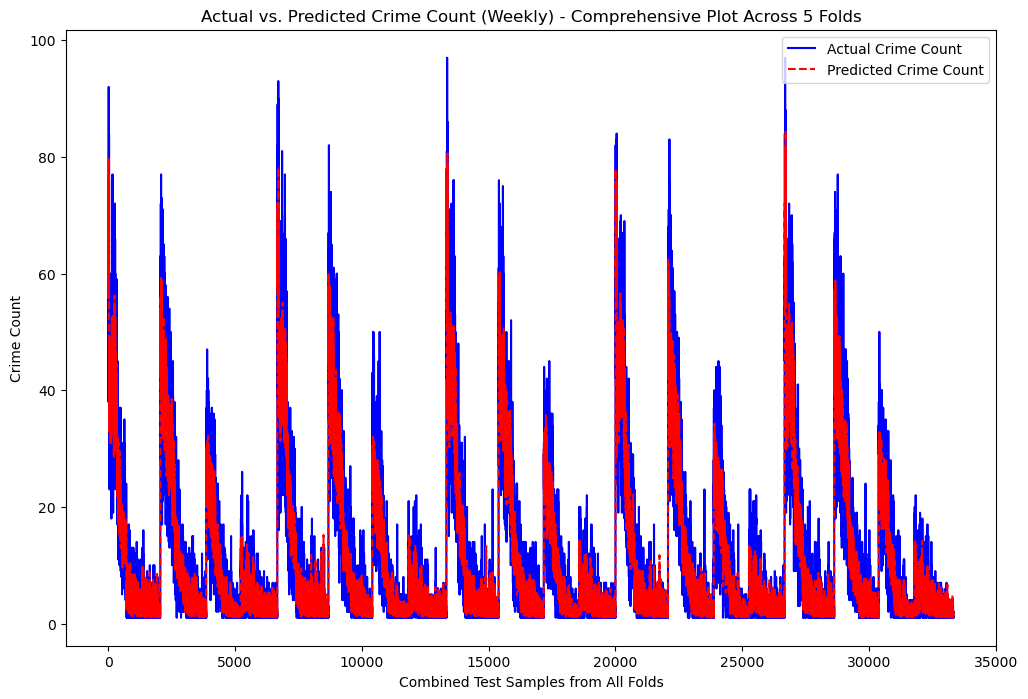

In [103]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(rf_model, X, y)

C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 1 Metrics:
  Mean Absolute Error (MAE): 2.5958013282435144
  Root Mean Squared Error (RMSE): 4.359450401159542
  R² Score: 0.8971141576766968



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 2 Metrics:
  Mean Absolute Error (MAE): 2.5941304820315967
  Root Mean Squared Error (RMSE): 4.431130924064588
  R² Score: 0.8982354402542114



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 3 Metrics:
  Mean Absolute Error (MAE): 2.576657363327447
  Root Mean Squared Error (RMSE): 4.319309935608491
  R² Score: 0.9009608030319214



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 4 Metrics:
  Mean Absolute Error (MAE): 2.5824349859510933
  Root Mean Squared Error (RMSE): 4.233474705200084
  R² Score: 0.9048807621002197



C:\Users\singh\anaconda3\lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold 5 Metrics:
  Mean Absolute Error (MAE): 2.6213048980496594
  Root Mean Squared Error (RMSE): 4.440972214493981
  R² Score: 0.8997926712036133

Average MAE across 5 folds: 2.594065811520662
Average RMSE across 5 folds: 4.356867636105338
Average R² Score across 5 folds: 0.9001967668533325


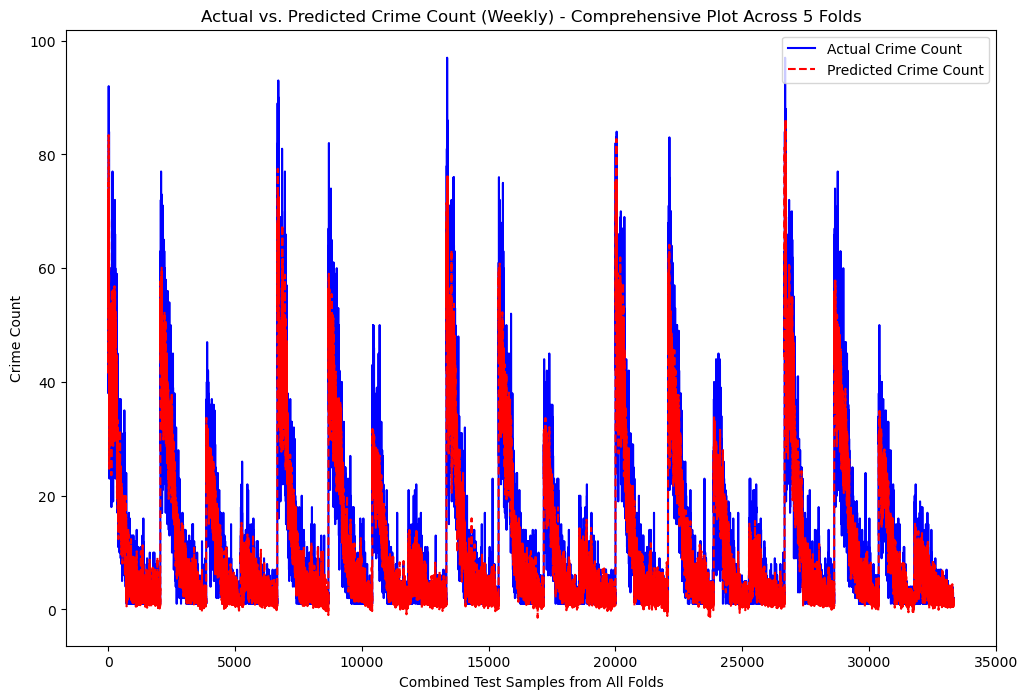

In [104]:
from xgboost import XGBRegressor
xgb_model = XGBRegressor(n_estimators=100, objective='reg:squarederror', random_state=42)
avg_mae, avg_rmse, avg_r2, metrics = k_fold_cross_validation(xgb_model, X, y)

In [25]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans

# Step 1: Aggregate weekly data as before
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).agg({
    'dow': 'mean',  
    'hour_of_day': 'mean',
    'extracted_month': 'mean',
    'extracted_day': 'mean',
    'temp_max': 'mean',
    'temp_min': 'mean',
    'daylight_duration': 'mean',
    'precipitation_sum': 'mean',
    'precipitation_hours': 'mean',
    'time_block_numeric': 'mean'
}).reset_index()

# Step 2: Add weekly crime count
crime_time_series['Crime_Count_W'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='W')]).size().values

# Step 3: Fit K-means clustering with 3 clusters on weekly crime counts
kmeans = KMeans(n_clusters=3, random_state=42)
crime_time_series['Cluster'] = kmeans.fit_predict(crime_time_series[['Crime_Count_W']])

# Step 4: Map clusters to "low," "medium," and "high" based on the cluster center values
cluster_centers = kmeans.cluster_centers_.flatten()
sorted_indices = np.argsort(cluster_centers)

# Create a dictionary to map cluster labels to "low" (0), "medium" (1), "high" (2)
cluster_mapping = {sorted_indices[0]: 0, sorted_indices[1]: 1, sorted_indices[2]: 2}
crime_time_series['Crime_Count_Bucket'] = crime_time_series['Cluster'].map(cluster_mapping)

# Clean up by dropping the 'Cluster' column
crime_time_series = crime_time_series.drop(columns=['Cluster'])

# Display the updated DataFrame
crime_time_series

,census_block_numeric,offense_date,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_W,Crime_Count_Bucket
0,0,2018-01-07,3.612903,10.774194,1.000000,3.419355,14.012673,2.872995,33396.085874,0.036132,8.258065,1.225806,62,2
1,0,2018-01-14,3.931818,13.840909,1.000000,10.727273,39.481495,25.380132,33891.959251,0.225304,8.454545,1.000000,44,2
2,0,2018-01-21,3.800000,14.171429,1.000000,18.028571,33.977197,18.672054,34573.083036,0.036670,4.057143,0.800000,35,1
3,0,2018-01-28,4.017857,12.696429,1.000000,24.625000,46.487669,32.168027,35307.395717,0.092238,7.750000,1.178571,56,2
4,0,2018-02-04,4.780488,11.317073,1.658537,11.878049,33.318698,17.041868,36302.567645,0.059823,7.024390,1.268293,41,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33332,239,2022-07-17,4.000000,0.000000,7.000000,13.000000,79.916000,63.986000,53716.195312,0.051181,4.000000,3.000000,1,0
33333,239,2022-07-31,1.000000,7.500000,7.000000,31.000000,83.606003,61.916000,51864.425781,0.000000,0.000000,1.500000,2,0
33334,239,2022-10-02,5.000000,17.000000,9.000000,29.000000,57.866001,44.456001,42640.847656,0.031496,4.000000,0.000000,1,0
33335,239,2022-12-04,5.000000,0.000000,12.000000,1.000000,33.206001,24.746000,33854.109375,0.007874,2.000000,3.000000,1,0


In [26]:
# Count of records in each bucket
bucket_counts = crime_time_series['Crime_Count_Bucket'].value_counts()
print("Bucket Counts:\n", bucket_counts)

# Summary statistics of Crime_Count_W by bucket
bucket_summary = crime_time_series.groupby('Crime_Count_Bucket')['Crime_Count_W'].describe()
print("Bucket Summary Statistics:\n", bucket_summary)

Bucket Counts:
 Crime_Count_Bucket
0    25227
1     5630
2     2480
Name: count, dtype: int64
Bucket Summary Statistics:
                       count       mean        std   min   25%   50%   75%  \
Crime_Count_Bucket                                                          
0                   25227.0   4.190788   3.468509   1.0   1.0   3.0   6.0   
1                    5630.0  23.850799   6.222308  15.0  18.0  23.0  29.0   
2                    2480.0  48.403629  10.114611  37.0  41.0  46.0  53.0   

                     max  
Crime_Count_Bucket        
0                   14.0  
1                   36.0  
2                   97.0  


In [27]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define features for each model component
spatial_features = ['census_block_numeric']
temporal_features = ['dow', 'hour_of_day', 'extracted_month', 'extracted_day', 
                     'temp_max', 'temp_min', 'daylight_duration', 'precipitation_sum', 
                     'precipitation_hours', 'time_block_numeric']

# Scale all features
scaler = MinMaxScaler()
crime_time_series[spatial_features + temporal_features] = scaler.fit_transform(crime_time_series[spatial_features + temporal_features])

# Prepare input (X) and target (y) arrays using the new binary target column
X_spatial = crime_time_series[spatial_features].values
X_temporal = crime_time_series[temporal_features].values
y = crime_time_series['Crime_Count_Bucket'].values  # Use binary bucket target
y = np.array(y)

# Define timesteps based on factor analysis or experiment with values
timesteps = 17

# Ensure all arrays are divisible by `timesteps`
num_samples = (X_temporal.shape[0] // timesteps) * timesteps
X_temporal = X_temporal[:num_samples].reshape((num_samples // timesteps, timesteps, len(temporal_features)))
X_spatial = X_spatial[:num_samples:timesteps]  # Reshape spatial data to align with temporal
y = y[:num_samples:timesteps]  # Align target array with reshaped temporal data

# Verify the shapes of X_temporal, X_spatial, and y are now the same length
print("Shapes after alignment:")
print("X_temporal:", X_temporal.shape)
print("X_spatial:", X_spatial.shape)
print("y:", y.shape)

# Split data chronologically for training and validation
X_temporal_train, X_temporal_val, X_spatial_train, X_spatial_val, y_train, y_val = train_test_split(
    X_temporal, X_spatial, y, test_size=0.2, random_state=42, shuffle=False
)

# Define input shapes for the model
temporal_input_shape = (timesteps, len(temporal_features))
spatial_input_shape = (1, 1, len(spatial_features))  # Spatial data as a single "pixel"

# Create TimeseriesGenerators
train_generator = TimeseriesGenerator(X_temporal_train, y_train, length=timesteps, batch_size=64)
val_generator = TimeseriesGenerator(X_temporal_val, y_val, length=timesteps, batch_size=64)

Shapes after alignment:
X_temporal: (1961, 17, 10)
X_spatial: (1961, 1)
y: (1961,)


Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 102ms/step - accuracy: 0.4161 - loss: 1.4377 - val_accuracy: 0.7557 - val_loss: 0.9995
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - accuracy: 0.7741 - loss: 1.3253 - val_accuracy: 0.7557 - val_loss: 0.8499
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - accuracy: 0.7531 - loss: 1.2794 - val_accuracy: 0.7557 - val_loss: 0.7203
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.7539 - loss: 1.2110 - val_accuracy: 0.7557 - val_loss: 0.5460
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7662 - loss: 1.0179 - val_accuracy: 0.7583 - val_loss: 0.4443
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7670 - loss: 0.8948 - val_accuracy: 0.8244 - val_loss: 0.4420
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.7978 - loss: 0.8529 - val_accuracy: 0.7659 - val_loss: 0.5069
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - accuracy: 0.7549 - loss: 0.8887 - val_accuracy: 0

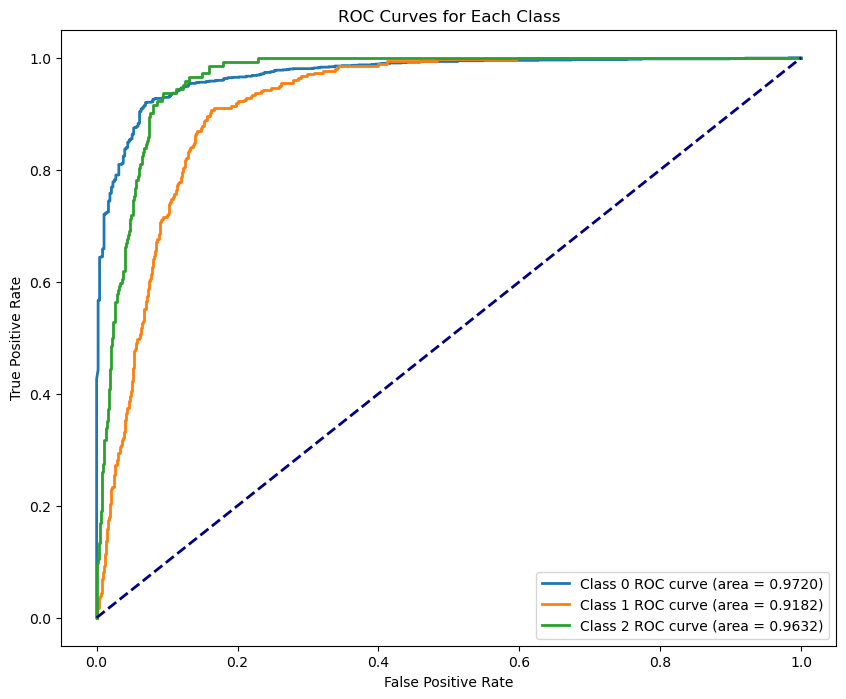

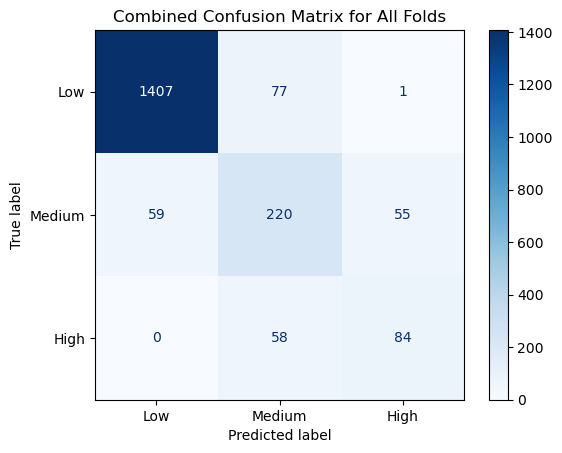

In [32]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, f1_score
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt

# Define the model in a function to allow re-instantiation
def create_model(temporal_input_shape, spatial_input_shape, lstm_units=64, gru_units=32, dropout_rate=0.3, learning_rate=0.001):
    temporal_input = Input(shape=temporal_input_shape, name="Temporal_Input")
    x = LSTM(lstm_units, activation='relu', return_sequences=True)(temporal_input)
    x = Dropout(dropout_rate)(x)
    x = GRU(gru_units, activation='relu', return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    spatial_input = Input(shape=spatial_input_shape, name="Spatial_Input")
    y = Conv2D(32, (1, 1), activation='relu')(spatial_input)
    y = MaxPooling2D(pool_size=(1, 1))(y)
    y = Flatten()(y)

    combined = concatenate([x, y])
    combined = Dense(16, activation='relu')(combined)
    output = Dense(3, activation='softmax', name="Output")(combined)

    model = Model(inputs=[temporal_input, spatial_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    
    return model

# Setting up Stratified K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
accuracy_scores = []
f1_scores = []
all_y_val = []
all_y_pred_prob = []

# Hyperparameters
lstm_units = 128
gru_units = 64
dropout_rate = 0.2
learning_rate = 0.0003
class_weights = {0: 1.0, 1: 2.0, 2: 3.0}  # Adjusted weights for Medium and High classes

# Iterate through each fold
for train_index, val_index in skf.split(X_temporal, y):
    X_temporal_train, X_temporal_val = X_temporal[train_index], X_temporal[val_index]
    X_spatial_train, X_spatial_val = X_spatial[train_index], X_spatial[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(
        temporal_input_shape=(X_temporal.shape[1], X_temporal.shape[2]), 
        spatial_input_shape=(1, 1, len(spatial_features)),
        lstm_units=lstm_units,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    history = model.fit(
        [X_temporal_train, X_spatial_train.reshape(-1, 1, 1, 1)],
        y_train,
        validation_data=([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)], y_val),
        epochs=100,
        batch_size=64,
        class_weight=class_weights,  # Apply class weights
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    y_pred_prob = model.predict([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)])
    
    # Collect predictions and true values for AUC, F1 scores, and confusion matrix
    all_y_val.extend(y_val)
    all_y_pred_prob.extend(y_pred_prob)
    y_pred_classes = np.argmax(y_pred_prob, axis=1)

    # Calculate and store metrics
    fold_auc = roc_auc_score(y_val, y_pred_prob, multi_class='ovr', average='macro')
    accuracy = accuracy_score(y_val, y_pred_classes)
    f1 = f1_score(y_val, y_pred_classes, average='macro')
    auc_scores.append(fold_auc)
    accuracy_scores.append(accuracy)
    f1_scores.append(f1)

    print(f"Fold AUC (OvR): {fold_auc:.4f}, Accuracy: {accuracy:.4f}, F1 Score: {f1:.4f}")

# Display mean and standard deviation of AUC, accuracy, and F1 score across all folds
print(f"\nAverage AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")
print(f"Average F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")

# Calculate AUC for each class individually
auc_per_class = roc_auc_score(all_y_val, all_y_pred_prob, multi_class='ovr', average=None)
for i, auc_score in enumerate(auc_per_class):
    print(f"AUC for class {i}: {auc_score:.4f}")

# Mean AUC across classes
mean_auc_per_class = np.mean(auc_per_class)
print(f"Mean AUC across classes: {mean_auc_per_class:.4f}")

# Create the comprehensive ROC curve for all classes
fpr = {}
tpr = {}
roc_auc = {}
for i in range(3):  # Assuming 3 classes
    fpr[i], tpr[i], _ = roc_curve(np.array(all_y_val) == i, np.array(all_y_pred_prob)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC for each class
plt.figure(figsize=(10, 8))
for i in range(3):
    plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {i} ROC curve (area = {roc_auc[i]:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Each Class')
plt.legend(loc="lower right")
plt.show()

# Create and display the confusion matrix for all folds combined
all_y_pred_classes = np.argmax(np.array(all_y_pred_prob), axis=1)
cm = confusion_matrix(all_y_val, all_y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low", "Medium", "High"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Combined Confusion Matrix for All Folds")
plt.show()

In [69]:
crime_time_series = crime.groupby(['census_block_numeric', pd.Grouper(freq='D')]).agg({
    'dow': 'first',  
    'hour_of_day': 'first',
    'extracted_month': 'first',
    'extracted_day': 'first',
    'temp_max': 'first',
    'temp_min': 'first',
    'daylight_duration': 'first',
    'precipitation_sum': 'first',
    'precipitation_hours': 'first',
    'time_block_numeric': 'first'
}).reset_index()

crime_time_series['Crime_Count_D'] = crime.groupby(['census_block_numeric', pd.Grouper(freq='D')]).size().values

# Step 1: Compute the median of weekly crime counts
median_count = crime_time_series['Crime_Count_D'].median()

# Step 2: Create buckets based on the median
crime_time_series['Crime_Count_Bucket'] = np.where(
    crime_time_series['Crime_Count_D'] >= median_count, 1, 0
)

crime_time_series = crime_time_series.sort_values(by='offense_date')

crime_time_series = crime_time_series.drop(columns=['offense_date'])

# Display the updated dataframe
crime_time_series

,census_block_numeric,dow,hour_of_day,extracted_month,extracted_day,temp_max,temp_min,daylight_duration,precipitation_sum,precipitation_hours,time_block_numeric,Crime_Count_D,Crime_Count_Bucket
0,0,2,17,1,1,11.570000,0.139999,33280.367188,0.051181,12.0,0,19,1
42711,71,2,0,1,1,11.827398,0.397396,33280.367188,0.051181,12.0,3,17,1
40901,70,2,0,1,1,12.878599,2.258602,33253.820312,0.082677,18.0,3,9,1
90102,138,2,9,1,1,14.008101,4.918100,33253.820312,0.082677,20.0,2,3,1
70201,94,2,15,1,1,11.897600,0.467596,33280.367188,0.051181,12.0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19134,10,7,20,1,1,45.700000,35.100000,33211.740000,0.035000,7.0,1,1,0
59190,80,7,19,1,1,49.820000,35.689999,33264.988281,0.007874,2.0,1,2,1
101804,190,7,21,1,1,50.147598,36.017601,33264.988281,0.007874,2.0,1,2,1
44512,71,7,21,1,1,49.139603,34.109600,33264.988281,0.011811,3.0,1,1,0


In [71]:
# Count of records in each bucket
bucket_counts = crime_time_series['Crime_Count_Bucket'].value_counts()
print("Bucket Counts:\n", bucket_counts)

# Summary statistics of Crime_Count_W by bucket
bucket_summary = crime_time_series.groupby('Crime_Count_Bucket')['Crime_Count_D'].describe()
print("Bucket Summary Statistics:\n", bucket_summary)

Bucket Counts:
 Crime_Count_Bucket
1    73663
0    41205
Name: count, dtype: int64
Bucket Summary Statistics:
                       count     mean       std  min  25%  50%  75%   max
Crime_Count_Bucket                                                      
0                   41205.0  1.00000  0.000000  1.0  1.0  1.0  1.0   1.0
1                   73663.0  4.32832  2.741352  2.0  2.0  3.0  6.0  33.0


In [74]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Define features for each model component
spatial_features = ['census_block_numeric']
temporal_features = ['dow', 'hour_of_day', 'extracted_month', 'extracted_day', 
                     'temp_max', 'temp_min', 'daylight_duration', 'precipitation_sum', 
                     'precipitation_hours', 'time_block_numeric']

# Scale all features
scaler = MinMaxScaler()
crime_time_series[spatial_features + temporal_features] = scaler.fit_transform(crime_time_series[spatial_features + temporal_features])

# Prepare input (X) and target (y) arrays using the new binary target column
X_spatial = crime_time_series[spatial_features].values
X_temporal = crime_time_series[temporal_features].values
y = crime_time_series['Crime_Count_Bucket'].values  # Use binary bucket target
y = np.array(y)

# Define timesteps based on factor analysis or experiment with values
timesteps = 7

# Ensure all arrays are divisible by `timesteps`
num_samples = (X_temporal.shape[0] // timesteps) * timesteps
X_temporal = X_temporal[:num_samples].reshape((num_samples // timesteps, timesteps, len(temporal_features)))
X_spatial = X_spatial[:num_samples:timesteps]  # Reshape spatial data to align with temporal
y = y[:num_samples:timesteps]  # Align target array with reshaped temporal data

# Verify the shapes of X_temporal, X_spatial, and y are now the same length
print("Shapes after alignment:")
print("X_temporal:", X_temporal.shape)
print("X_spatial:", X_spatial.shape)
print("y:", y.shape)

# Split data chronologically for training and validation
X_temporal_train, X_temporal_val, X_spatial_train, X_spatial_val, y_train, y_val = train_test_split(
    X_temporal, X_spatial, y, test_size=0.2, random_state=42, shuffle=False
)

# Define input shapes for the model
temporal_input_shape = (timesteps, len(temporal_features))
spatial_input_shape = (1, 1, len(spatial_features))  # Spatial data as a single "pixel"

# Create TimeseriesGenerators
train_generator = TimeseriesGenerator(X_temporal_train, y_train, length=timesteps, batch_size=64)
val_generator = TimeseriesGenerator(X_temporal_val, y_val, length=timesteps, batch_size=64)

Shapes after alignment:
X_temporal: (16409, 7, 10)
X_spatial: (16409, 1)
y: (16409,)


Epoch 1/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.6327 - loss: 0.6644 - val_accuracy: 0.6380 - val_loss: 0.6387
Epoch 2/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.6437 - loss: 0.6365 - val_accuracy: 0.6627 - val_loss: 0.6283
Epoch 3/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6621 - loss: 0.6314 - val_accuracy: 0.6630 - val_loss: 0.6254
Epoch 4/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - accuracy: 0.6690 - loss: 0.6276 - val_accuracy: 0.6676 - val_loss: 0.6253
Epoch 5/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - accuracy: 0.6631 - loss: 0.6283 - val_accuracy: 0.6709 - val_loss: 0.6260
Epoch 6/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6714 - loss: 0.6255 - val_accuracy: 0.6712 - val_loss: 0.6257
Epoch 7/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - accuracy: 0.6670 - loss: 0.6314 - val_accuracy: 0.6670 - val_loss: 0.6244
Epoch 8/100
206/206 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - accuracy: 0.6709 - loss: 0.6278 - 

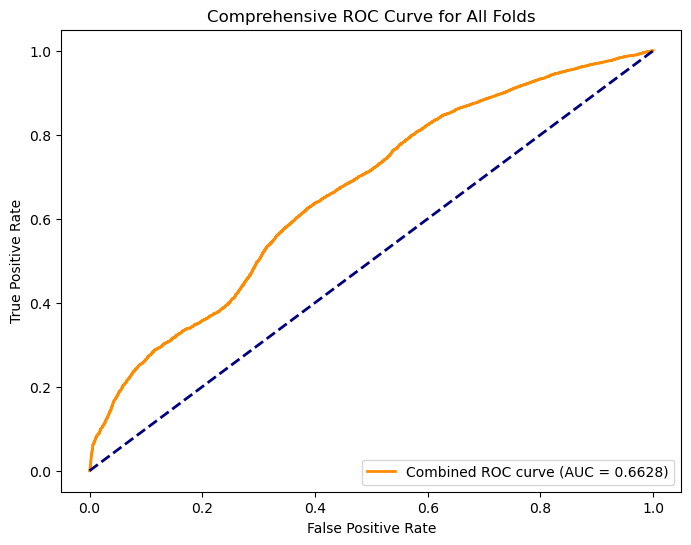

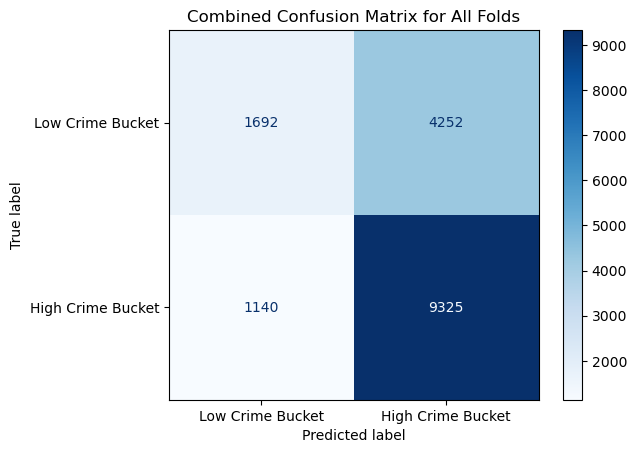

In [75]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, GRU, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import KFold
import numpy as np
import matplotlib.pyplot as plt

# Define the model in a function to allow re-instantiation
def create_model(temporal_input_shape, spatial_input_shape, lstm_units=64, gru_units=32, dropout_rate=0.3, learning_rate=0.001):
    temporal_input = Input(shape=temporal_input_shape, name="Temporal_Input")
    x = LSTM(lstm_units, activation='relu', return_sequences=True)(temporal_input)
    x = Dropout(dropout_rate)(x)
    x = GRU(gru_units, activation='relu', return_sequences=False)(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(16, activation='relu')(x)

    spatial_input = Input(shape=spatial_input_shape, name="Spatial_Input")
    y = Conv2D(32, (1, 1), activation='relu')(spatial_input)
    y = MaxPooling2D(pool_size=(1, 1))(y)
    y = Flatten()(y)

    combined = concatenate([x, y])
    combined = Dense(16, activation='relu')(combined)
    output = Dense(1, activation='sigmoid', name="Output")(combined)

    model = Model(inputs=[temporal_input, spatial_input], outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Set up K-Fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
auc_scores = []
accuracy_scores = []
all_y_val = []
all_y_pred_prob = []

# Hyperparameters to try
lstm_units = 128
gru_units = 64
dropout_rate = 0.2
learning_rate = 0.0005

# Iterate through each fold
for train_index, val_index in kf.split(X_temporal):
    X_temporal_train, X_temporal_val = X_temporal[train_index], X_temporal[val_index]
    X_spatial_train, X_spatial_val = X_spatial[train_index], X_spatial[val_index]
    y_train, y_val = y[train_index], y[val_index]

    model = create_model(
        temporal_input_shape=(X_temporal.shape[1], X_temporal.shape[2]), 
        spatial_input_shape=(1, 1, len(spatial_features)),
        lstm_units=lstm_units,
        gru_units=gru_units,
        dropout_rate=dropout_rate,
        learning_rate=learning_rate
    )

    history = model.fit(
        [X_temporal_train, X_spatial_train.reshape(-1, 1, 1, 1)],
        y_train,
        validation_data=([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)], y_val),
        epochs=100,
        batch_size=64,
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

    y_pred_prob = model.predict([X_temporal_val, X_spatial_val.reshape(-1, 1, 1, 1)]).flatten()
    y_pred_classes = (y_pred_prob > 0.5).astype(int)

    # Collect predictions and true values for the combined AUC and confusion matrix
    all_y_val.extend(y_val)
    all_y_pred_prob.extend(y_pred_prob)

    # Rename `auc` variable to avoid conflict with `auc` function
    fold_auc = roc_auc_score(y_val, y_pred_prob)
    accuracy = accuracy_score(y_val, y_pred_classes)
    auc_scores.append(fold_auc)
    accuracy_scores.append(accuracy)

    print(f"Fold AUC: {fold_auc:.4f}, Accuracy: {accuracy:.4f}")

# Display mean and standard deviation of AUC and accuracy across all folds
print(f"\nAverage AUC: {np.mean(auc_scores):.4f} ± {np.std(auc_scores):.4f}")
print(f"Average Accuracy: {np.mean(accuracy_scores):.4f} ± {np.std(accuracy_scores):.4f}")

# Create the comprehensive ROC curve for all folds combined
fpr, tpr, thresholds = roc_curve(all_y_val, all_y_pred_prob)
combined_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Combined ROC curve (AUC = {combined_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')  # Diagonal line for random guessing
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comprehensive ROC Curve for All Folds')
plt.legend(loc="lower right")
plt.show()

# Create and display the confusion matrix for all folds combined
all_y_pred_classes = (np.array(all_y_pred_prob) > 0.5).astype(int)
cm = confusion_matrix(all_y_val, all_y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Low Crime Bucket", "High Crime Bucket"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Combined Confusion Matrix for All Folds")
plt.show()